In [24]:
!git clone -b reduce_features https://github.com/lahirumanulanka/ann-visual-emotion

fatal: destination path 'ann-visual-emotion' already exists and is not an empty directory.


# CNN Transfer Learning for Visual Emotion Recognition

This notebook demonstrates how to implement transfer learning with CNN networks for visual emotion recognition. We'll use a pre-trained VGG16 model and fine-tune it for our emotion classification task.

## Step 1: Import Required Libraries

In [25]:
import os
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Sklearn for metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## Step 2: Data Preparation

First, let's set up our data paths and load the dataset splits.

In [26]:
# Data paths (modify these if running locally)

PROJECT_ROOT = Path('/content/ann-visual-emotion')
CSV_TRAIN = PROJECT_ROOT / 'data/processed/EmoSet_splits/train.csv'
CSV_VAL = PROJECT_ROOT / 'data/processed/EmoSet_splits/val.csv'
CSV_TEST = PROJECT_ROOT / 'data/processed/EmoSet_splits/test.csv'
LABEL_MAP_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/label_map.json'
DATA_DIR = PROJECT_ROOT / 'data/raw/EmoSet'

# Check if files exist
print("Checking data files...")
for path in [CSV_TRAIN, CSV_VAL, CSV_TEST, LABEL_MAP_PATH]:
    if path.exists():
        print(f"✓ Found: {path}")
    else:
        print(f"✗ Missing: {path}")

# Load label map if it exists
if LABEL_MAP_PATH.exists():
    with open(LABEL_MAP_PATH, 'r') as f:
        label_map = json.load(f)
    num_classes = len(label_map)
    print(f'Number of emotion classes: {num_classes}')
    print(f'Emotion classes: {list(label_map.keys())}')
else:
    # Create a dummy label map for testing
    label_map = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5, 'neutral': 6}
    num_classes = len(label_map)
    print(f'Using dummy label map with {num_classes} classes: {list(label_map.keys())}')

Checking data files...
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json
Number of emotion classes: 5
Emotion classes: ['angry', 'happy', 'neutral', 'sad', 'surprise']


## (Optional) Step 2b: Generate 224×224 Resized Dataset and Updated CSV Splits

In case your original FER-style images are 48×48 (grayscale) and you want to:

1. Upscale them to 224×224 (required for many ImageNet pre-trained backbones).
2. Store the resized copies in a separate folder structure (`class` subfolders).
3. Regenerate new CSV split files (`train_224.csv`, `val_224.csv`, `test_224.csv`) that point directly to the resized images.
4. Produce an updated stats file (`stats_resized_224.json`) summarizing counts per class.

You can run the following cells once. They are resume-friendly (will skip already processed files by default). Set `FORCE_OVERWRITE = True` to re-create images.

If you already have resized images / CSVs, you can skip this section and set `USE_RESIZED_SPLITS = True` later to automatically pick them up for training.

In [27]:
from pathlib import Path
import pandas as pd
from PIL import Image
from tqdm import tqdm
import json

# Configuration for resizing
RESIZE_ROOT = PROJECT_ROOT  # base project root (already defined earlier)
RAW_IMG_ROOT = PROJECT_ROOT / 'data/raw/EmoSet'
PROCESSED_SPLITS_DIR = PROJECT_ROOT / 'data/processed/EmoSet_splits'
RESIZED_OUT_DIR = PROJECT_ROOT / 'data/processed/EmoSet_resized_224'
RESIZED_IMG_DIR = RESIZED_OUT_DIR / 'images_224'
RESIZED_SPLIT_DIR = RESIZED_OUT_DIR / 'splits'
RESIZED_STATS_PATH = RESIZED_OUT_DIR / 'stats_resized_224.json'

# Control flags
SKIP_IF_EXISTS = True       # Don't re-generate images if target file exists
FORCE_OVERWRITE = False     # If True, ignore SKIP_IF_EXISTS
USE_RESIZED_SPLITS = True   # Later, if True and splits exist, training section will use them
GRAYSCALE_SOURCE = True     # If original images are grayscale 48x48
TARGET_SIZE = (224, 224)

RESIZED_IMG_DIR.mkdir(parents=True, exist_ok=True)
RESIZED_SPLIT_DIR.mkdir(parents=True, exist_ok=True)

SUPPORTED_PATH_COLS  = ["path", "filepath", "file_path", "image_path", "img_path"]
SUPPORTED_LABEL_COLS = ["label", "class", "emotion", "target", "y", "label_id"]


def robust_read_csv(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df.rename(columns={c: c.strip().lower() for c in df.columns}, inplace=True)
    path_col = next((c for c in SUPPORTED_PATH_COLS if c in df.columns), None)
    label_col = next((c for c in SUPPORTED_LABEL_COLS if c in df.columns), None)
    if path_col is None or label_col is None:
        raise AssertionError(f"CSV must contain a path+label column. Found columns: {list(df.columns)}")
    out = df[[path_col, label_col]].copy()
    out.columns = ["path", "label"]
    out["label"] = out["label"].astype(str)
    return out


def resolve_path(p: str) -> Path:
    pth = Path(p)
    if pth.exists():
        return pth
    alt = RAW_IMG_ROOT / pth
    return alt if alt.exists() else alt  # return alt even if missing for error reporting


def out_path_for(in_path: Path, label: str) -> Path:
    out_dir = RESIZED_IMG_DIR / label
    out_dir.mkdir(parents=True, exist_ok=True)
    return out_dir / (in_path.stem + '.jpg')


def resize_to_target(img: Image.Image) -> Image.Image:
    if GRAYSCALE_SOURCE:
        img = img.convert('L')  # ensure grayscale
        # convert to 3-channel RGB for pre-trained models after resizing
        img = img.resize(TARGET_SIZE, resample=Image.BICUBIC).convert('RGB')
    else:
        img = img.convert('RGB').resize(TARGET_SIZE, resample=Image.BICUBIC)
    return img


def process_split(csv_path: Path, out_csv_path: Path):
    if not csv_path.exists():
        print(f"[skip] Missing split file: {csv_path}")
        return None

    df = robust_read_csv(csv_path)
    rows = []
    print(f"Processing {csv_path.name} -> {out_csv_path.name}  (n={len(df)})")

    for r in tqdm(df.itertuples(index=False), total=len(df)):
        in_path = resolve_path(r.path)
        label = str(r.label)
        out_img_path = out_path_for(in_path, label)

        if FORCE_OVERWRITE is False and SKIP_IF_EXISTS and out_img_path.exists():
            rows.append({"path": str(out_img_path.relative_to(PROJECT_ROOT)), "label": label})
            continue

        try:
            img = Image.open(in_path)
            img224 = resize_to_target(img)
            out_img_path.parent.mkdir(parents=True, exist_ok=True)
            img224.save(out_img_path, format='JPEG', quality=95)
            rows.append({"path": str(out_img_path.relative_to(PROJECT_ROOT)), "label": label})
        except Exception as e:
            print(f"[error] {in_path}: {e}")

    if rows:
        out_df = pd.DataFrame(rows)
        out_df.to_csv(out_csv_path, index=False)
        print(f"Wrote {out_csv_path} (rows={len(out_df)})")
    else:
        print(f"No rows written for {csv_path}")
    return rows

# Run resizing for splits if original CSVs exist
resized_train_csv = RESIZED_SPLIT_DIR / 'train_224.csv'
resized_val_csv = RESIZED_SPLIT_DIR / 'val_224.csv'
resized_test_csv = RESIZED_SPLIT_DIR / 'test_224.csv'

if CSV_TRAIN.exists():
    process_split(CSV_TRAIN, resized_train_csv)
if CSV_VAL.exists():
    process_split(CSV_VAL, resized_val_csv)
if CSV_TEST.exists():
    process_split(CSV_TEST, resized_test_csv)

# Aggregate stats
if resized_train_csv.exists():
    train_df_r = pd.read_csv(resized_train_csv)
    cls_counts = train_df_r['label'].value_counts().to_dict()
    stats = {
        'total_train_images': int(len(train_df_r)),
        'classes': cls_counts,
        'num_classes': int(len(cls_counts)),
        'target_size': list(TARGET_SIZE),
        'grayscale_source': GRAYSCALE_SOURCE,
    }
    with open(RESIZED_STATS_PATH, 'w') as f:
        json.dump(stats, f, indent=2)
    print(f"Wrote stats: {RESIZED_STATS_PATH}")
else:
    print("Resized training CSV not found; skipping stats generation.")

Processing train.csv -> train_224.csv  (n=20150)


100%|██████████| 20150/20150 [00:02<00:00, 8976.74it/s]


Wrote /content/ann-visual-emotion/data/processed/EmoSet_resized_224/splits/train_224.csv (rows=20150)
Processing val.csv -> val_224.csv  (n=4030)


100%|██████████| 4030/4030 [00:00<00:00, 9001.25it/s]


Wrote /content/ann-visual-emotion/data/processed/EmoSet_resized_224/splits/val_224.csv (rows=4030)
Processing test.csv -> test_224.csv  (n=1005)


100%|██████████| 1005/1005 [00:00<00:00, 9169.22it/s]

Wrote /content/ann-visual-emotion/data/processed/EmoSet_resized_224/splits/test_224.csv (rows=1005)
Wrote stats: /content/ann-visual-emotion/data/processed/EmoSet_resized_224/stats_resized_224.json


## Step 3: Custom Dataset Class

We'll create a custom dataset class that handles both grayscale and RGB images for transfer learning.

In [28]:
class EmotionDataset(Dataset):
    """
    Custom dataset class for emotion recognition.
    Supports both grayscale and RGB images for transfer learning.
    """

    def __init__(self, dataframe, root_dir, transform=None, label_map=None, rgb=True):
        """
        Args:
            dataframe: pandas DataFrame with image paths and labels
            root_dir: Root directory containing images
            transform: Optional transform to be applied on images
            label_map: Dictionary mapping emotion names to indices
            rgb: If True, convert grayscale images to RGB for pre-trained models
        """
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.label_map = label_map
        self.rgb = rgb

        # Auto-detect column names
        possible_path_cols = [c for c in self.df.columns if 'path' in c.lower() or 'file' in c.lower() or 'image' in c.lower()]
        self.path_col = possible_path_cols[0] if possible_path_cols else self.df.columns[0]

        possible_label_cols = [c for c in self.df.columns if 'label' in c.lower() or 'class' in c.lower() or 'emotion' in c.lower()]
        self.label_col = possible_label_cols[0] if possible_label_cols else self.df.columns[1]

        print(f"Using columns - Path: '{self.path_col}', Label: '{self.label_col}'")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rel_path = row[self.path_col]
        label = row[self.label_col]

        # Convert label to index if needed
        if self.label_map and isinstance(label, str):
            label_idx = self.label_map[label]
        else:
            label_idx = int(label)

        # Load image
        img_path = self.root_dir / rel_path

        try:
            if self.rgb:
                # Load as RGB for pre-trained models
                image = Image.open(img_path).convert('RGB')
            else:
                # Load as grayscale
                image = Image.open(img_path).convert('L')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image in case of error
            if self.rgb:
                image = Image.new('RGB', (48, 48), color='black')
            else:
                image = Image.new('L', (48, 48), color='black')

        if self.transform:
            image = self.transform(image)

        return image, label_idx

## Step 4: Data Transforms for Transfer Learning

For transfer learning with pre-trained models, we need to:
1. Resize images to the expected input size (224x224 for VGG)
2. Normalize with ImageNet statistics
3. Apply data augmentation for training

In [29]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), value='random')
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

## Step 5: Create Datasets and DataLoaders

In [30]:
# Create dummy datasets if actual data files don't exist
if not all(path.exists() for path in [CSV_TRAIN, CSV_VAL, CSV_TEST]):
    print("Creating dummy datasets for demonstration...")

    # Create dummy data
    dummy_data = {
        'image_path': [f'dummy_{i}.jpg' for i in range(100)],
        'emotion': np.random.choice(list(label_map.keys()), 100)
    }

    train_df = pd.DataFrame(dummy_data)
    val_df = pd.DataFrame(dummy_data)
    test_df = pd.DataFrame(dummy_data)

    print("Using dummy datasets (replace with actual data loading when available)")
else:
    # Load actual datasets, choose resized if requested
    print("Loading datasets...")
    use_resized = False
    if 'USE_RESIZED_SPLITS' in globals() and USE_RESIZED_SPLITS:
        candidate_train = PROJECT_ROOT / 'data/processed/EmoSet_resized_224/splits/train_224.csv'
        candidate_val = PROJECT_ROOT / 'data/processed/EmoSet_resized_224/splits/val_224.csv'
        candidate_test = PROJECT_ROOT / 'data/processed/EmoSet_resized_224/splits/test_224.csv'
        if candidate_train.exists():
            print("✓ Using resized 224×224 split CSVs")
            CSV_TRAIN_ACTIVE = candidate_train
            CSV_VAL_ACTIVE = candidate_val if candidate_val.exists() else CSV_VAL
            CSV_TEST_ACTIVE = candidate_test if candidate_test.exists() else CSV_TEST
            use_resized = True
        else:
            print("Resized splits not found; falling back to original CSVs")
            CSV_TRAIN_ACTIVE, CSV_VAL_ACTIVE, CSV_TEST_ACTIVE = CSV_TRAIN, CSV_VAL, CSV_TEST
    else:
        CSV_TRAIN_ACTIVE, CSV_VAL_ACTIVE, CSV_TEST_ACTIVE = CSV_TRAIN, CSV_VAL, CSV_TEST

    train_df = pd.read_csv(CSV_TRAIN_ACTIVE)
    val_df = pd.read_csv(CSV_VAL_ACTIVE) if CSV_VAL_ACTIVE.exists() else pd.read_csv(CSV_TRAIN_ACTIVE).sample(frac=0.2, random_state=42)
    test_df = pd.read_csv(CSV_TEST_ACTIVE) if CSV_TEST_ACTIVE.exists() else pd.read_csv(CSV_TRAIN_ACTIVE).sample(frac=0.2, random_state=123)

    if use_resized:
        # Paths in resized CSVs are relative to project root already (we made them relative earlier)
        DATA_DIR = PROJECT_ROOT  # so concatenation below works
        print("DATA_DIR adjusted to project root for resized relative paths.")

print(f"Dataset sizes:")
print(f"- Training: {len(train_df)}")
print(f"- Validation: {len(val_df)}")
print(f"- Testing: {len(test_df)}")

# Create datasets (using RGB for transfer learning)
train_dataset = EmotionDataset(train_df, DATA_DIR, transform=train_transform,
                              label_map=label_map, rgb=True)
val_dataset = EmotionDataset(val_df, DATA_DIR, transform=val_transform,
                            label_map=label_map, rgb=True)
test_dataset = EmotionDataset(test_df, DATA_DIR, transform=val_transform,
                             label_map=label_map, rgb=True)

# Create data loaders
BATCH_SIZE = 32
class_counts = Counter(train_df['label'])
class_weights = torch.tensor(
    [1.0 / class_counts[c] for c in train_df['label']],
    dtype=torch.float
)
sample_weights = class_weights
sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"DataLoaders created with batch size: {BATCH_SIZE}")

Loading datasets...
✓ Using resized 224×224 split CSVs
DATA_DIR adjusted to project root for resized relative paths.
Dataset sizes:
- Training: 20150
- Validation: 4030
- Testing: 1005
Using columns - Path: 'path', Label: 'label'
Using columns - Path: 'path', Label: 'label'
Using columns - Path: 'path', Label: 'label'
DataLoaders created with batch size: 32



## What is Transfer Learning?
Transfer learning is a machine learning technique where we use a model that has been trained on one task and adapt it for a related task. In our case, we'll use a CNN pre-trained on ImageNet and adapt it for emotion recognition.

## Benefits of Transfer Learning:
1. **Faster training**: We start with pre-trained weights instead of random initialization
2. **Better performance**: Especially when we have limited training data
3. **Lower computational requirements**: Less training time needed
4. **Proven feature extractors**: Pre-trained networks have learned robust low-level features

## CNN Transfer Learning Model

Now we'll create our transfer learning model using a pre-trained VGG16 network.

### Transfer Learning Strategies:
1. **Feature Extraction**: Freeze pre-trained layers, only train classifier
2. **Fine-tuning**: Train all layers with very small learning rate
3. **Gradual unfreezing**: Start with frozen layers, gradually unfreeze

We'll implement strategy #2 (fine-tuning) as it typically gives the best results.

In [31]:
from torchvision import models
from torchvision.models import (
    VGG16_Weights, VGG19_Weights, AlexNet_Weights,
    ResNet18_Weights
)

class CNNTransferLearning(nn.Module):
    """
    Transfer Learning head over a pretrained backbone.
    - Supports: vgg16, vgg19, alexnet, resnet18
    - Uses AdaptiveAvgPool2d((1,1)) so output dim = last conv channels (robust to input size)
    - Freeze strategy: 'all' (features frozen), 'none' (full finetune), 'partial' (unfreeze last block only for VGG/ResNet)
    """

    def __init__(self,
                 num_classes: int,
                 backbone: str = 'vgg16',
                 pretrained: bool = True,
                 freeze_mode: str = 'none',   # 'all' | 'none' | 'partial'
                 classifier_hidden: int = 512 # compact head since 1x1 pooling
                 ):
        super().__init__()
        self.backbone_name = backbone.lower()
        self.num_classes = num_classes
        self.freeze_mode = freeze_mode

        # ---- Load backbone with new Weights API
        if self.backbone_name == 'vgg16':
            weights = VGG16_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.vgg16(weights=weights)
            self.features = net.features                  # conv stack
            last_channels = 512                           # VGG16 last conv planes
        elif self.backbone_name == 'vgg19':
            weights = VGG19_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.vgg19(weights=weights)
            self.features = net.features
            last_channels = 512
        elif self.backbone_name == 'alexnet':
            weights = AlexNet_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.alexnet(weights=weights)
            self.features = net.features
            last_channels = 256                           # AlexNet last conv planes
        elif self.backbone_name == 'resnet18':
            weights = ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
            net = models.resnet18(weights=weights)
            # build a conv feature extractor (everything except avgpool & fc)
            self.features = nn.Sequential(
                net.conv1, net.bn1, net.relu, net.maxpool,
                net.layer1, net.layer2, net.layer3, net.layer4
            )
            last_channels = 512
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # ---- Robust pooling to handle arbitrary input sizes
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))   # -> [B, C, 1, 1]
        feature_dim = last_channels                    # flatten -> [B, C]

        # ---- Freeze strategy
        if freeze_mode not in ('all', 'none', 'partial'):
            raise ValueError("freeze_mode must be 'all' | 'none' | 'partial'")

        if freeze_mode == 'all':
            for p in self.features.parameters():
                p.requires_grad = False
            print(f"[Freeze] backbone ALL layers frozen.")
        elif freeze_mode == 'partial':
            # Freeze all first
            for p in self.features.parameters():
                p.requires_grad = False
            # Unfreeze the last block only (heuristics per backbone)
            self._unfreeze_last_block()
            print(f"[Freeze] backbone PARTIAL: last block unfrozen.")
        else:
            print(f"[Freeze] backbone NONE: full finetuning.")

        # ---- Compact classifier (since feature_dim is small)
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.ReLU(inplace=True),
            nn.LayerNorm(512),
            nn.Dropout(0.25),
            nn.Linear(512, num_classes)
        )
        self._initialize_classifier()

        print(f"Model: backbone={self.backbone_name} pretrained={pretrained} "
              f"freeze_mode={freeze_mode} feature_dim={feature_dim} classes={num_classes}")

    # === helpers ===
    def _initialize_classifier(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def _unfreeze_last_block(self):
        """
        Unfreezes only the last stage of the backbone (good for small datasets).
        Heuristics per-architecture to keep code simple.
        """
        if self.backbone_name in ('vgg16', 'vgg19', 'alexnet'):
            # features is a Sequential of conv/pool layers; unfreeze last ~5 layers
            # (VGG block5 roughly ~ last 5 layers with conv+relu)
            k = 5
            for m in list(self.features.children())[-k:]:
                for p in m.parameters():
                    p.requires_grad = True
        elif self.backbone_name == 'resnet18':
            # Unfreeze only layer4 (last residual stage)
            for m in self.features[-1].modules():  # self.features[-1] == layer4
                for p in m.parameters():
                    p.requires_grad = True

    def forward(self, x):
        x = self.features(x)        # [B,C,H,W]
        x = self.avgpool(x)         # [B,C,1,1]
        x = torch.flatten(x, 1)     # [B,C]
        return self.classifier(x)

    # Optional: parameter groups for different LRs
    def param_groups(self):
        backbone_params = [p for p in self.features.parameters() if p.requires_grad]
        head_params     = list(self.classifier.parameters())
        return {'backbone': backbone_params, 'head': head_params}

    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 5

model = CNNTransferLearning(
    num_classes=num_classes,
    backbone='resnet18',          # 'vgg16' | 'vgg19' | 'alexnet' | 'resnet18'
    pretrained=True,
    freeze_mode='none',      # 'all' (smallest data) | 'partial' (small data) | 'none' (big data)
    classifier_hidden=512
).to(device)

print(f"Trainable params: {model.get_num_params():,}")

[Freeze] backbone NONE: full finetuning.
Model: backbone=resnet18 pretrained=True freeze_mode=none feature_dim=512 classes=5
Trainable params: 11,442,757


## Step 7: Training Setup

For transfer learning, we need to use different learning rates:
- Smaller learning rate for pre-trained layers (if unfrozen)
- Regular learning rate for new classifier layers

In [32]:
import math # Import the math module

# Loss function
# Assume: model, train_loader, val_loader already created
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# (Optional) class weights for imbalance: tensor of shape [num_classes]
# class_weights = torch.tensor([...], dtype=torch.float, device=device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # default

total_epochs = 50
warmup_epochs = 3
base_lr_backbone = 1e-4
base_lr_head = 1e-3

# Get parameter groups from the model
pg = model.param_groups()

optimizer = torch.optim.Adam([
    {'params': pg['backbone'], 'lr': base_lr_backbone},
    {'params': pg['head'], 'lr': base_lr_head},
], weight_decay=1e-4)

def cosine_lr(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=[cosine_lr, cosine_lr]
)

# Mixed precision scaler (only if CUDA)
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

/tmp/ipython-input-2051140336.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None


## Step 8: Training Functions

Let's create training and validation functions with proper progress tracking.

In [33]:
import torch
from torch import nn
from typing import Optional, Tuple, List

use_mixup = True
mixup_alpha = 0.4   # Typical: 0.2–0.4. Set 0 or False to disable quickly.

def train_epoch(
    model: nn.Module,
    train_loader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    scaler: Optional[torch.cuda.amp.GradScaler] = None,
    progress_every: int = 100,
    max_grad_norm: Optional[float] = None,
) -> Tuple[float, float]:
    """
    Train the model for one epoch with mixed precision, optional grad clipping, and progress logging.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    use_amp = (scaler is not None)

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad(set_to_none=True)

        if use_amp:
            with torch.cuda.amp.autocast():
                output = model(data)
                loss = criterion(output, target)
            scaler.scale(loss).backward()
            if max_grad_norm is not None:
                # Unscale first, then clip
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()

        running_loss += float(loss.detach())
        pred = output.argmax(dim=1)
        total += target.size(0)
        correct += (pred == target).sum().item()

        if progress_every and (batch_idx % progress_every == 0) and (batch_idx > 0):
            print(f'    [Epoch {epoch}] Batch {batch_idx}/{len(train_loader)} '
                  f'Loss={running_loss/(batch_idx+1):.4f} '
                  f'Acc={100.0*correct/total:.2f}%')

    epoch_loss = running_loss / max(1, len(train_loader))
    epoch_acc  = 100.0 * correct / max(1, total)
    return epoch_loss, epoch_acc


def validate_epoch(
    model: nn.Module,
    val_loader,
    criterion: nn.Module,
    device: torch.device,
    use_amp: bool = True
) -> Tuple[float, float, List[int], List[int]]:
    """
    Validate the model with no grad. Uses autocast by default for speed.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions: List[int] = []
    all_targets: List[int] = []

    with torch.no_grad():
        amp_ctx = torch.cuda.amp.autocast() if (use_amp and device.type == 'cuda') else torch.cuda.amp.autocast(enabled=False)
        with amp_ctx:
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                running_loss += float(loss)
                pred = output.argmax(dim=1)
                total += target.size(0)
                correct += (pred == target).sum().item()

                all_predictions.extend(pred.detach().cpu().tolist())
                all_targets.extend(target.detach().cpu().tolist())

    epoch_loss = running_loss / max(1, len(val_loader))
    epoch_acc  = 100.0 * correct / max(1, total)
    return epoch_loss, epoch_acc, all_predictions, all_targets

## Step 9: Training Loop with Early Stopping

In [34]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs=30, patience=5, save_path='best_cnn_transfer_model.pth'):
    """
    Train the model with early stopping.
    """
    print(f"\n{'='*60}")
    print(f"STARTING TRAINING - CNN TRANSFER LEARNING")
    print(f"{'='*60}")
    print(f"Epochs: {num_epochs}, Patience: {patience}")
    print(f"Device: {device}")
    print()

    best_val_acc = 0.0
    patience_counter = 0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)

        # Validation phase
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e} (backbone), {optimizer.param_groups[1]['lr']:.2e} (classifier)")

        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            }, save_path)
            print(f"✓ New best model saved! Val Acc: {best_val_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")

        print()

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print(f"Training completed!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

print("Training function defined. Ready to start training!")

Training function defined. Ready to start training!


## Step 10: Start Training

Note: If running with dummy data, this will not produce meaningful results. Replace with actual data for real training.

In [35]:
# Check if we have actual data or dummy data
if DATA_DIR.exists() and any(DATA_DIR.iterdir()):
    print("Starting training with actual data...")
    EPOCHS = 50
else:
    print("Using dummy data - training for demonstration only...")
    EPOCHS = 3  # Shorter training for demo

# Start training
training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=EPOCHS,
    patience=3
)

Starting training with actual data...

STARTING TRAINING - CNN TRANSFER LEARNING
Epochs: 50, Patience: 3
Device: cuda

Epoch 1/50
----------------------------------------
    [Epoch 0] Batch 100/630 Loss=1.6764 Acc=36.29%
    [Epoch 0] Batch 200/630 Loss=1.5131 Acc=41.14%
    [Epoch 0] Batch 300/630 Loss=1.4165 Acc=45.38%
    [Epoch 0] Batch 400/630 Loss=1.3483 Acc=48.26%
    [Epoch 0] Batch 500/630 Loss=1.2939 Acc=50.70%
    [Epoch 0] Batch 600/630 Loss=1.2527 Acc=52.49%


/tmp/ipython-input-1359432794.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  amp_ctx = torch.cuda.amp.autocast() if (use_amp and device.type == 'cuda') else torch.cuda.amp.autocast(enabled=False)


Train Loss: 1.2420, Train Acc: 52.93%
Val Loss: 0.9730, Val Acc: 65.53%
Current LR: 6.67e-05 (backbone), 6.67e-04 (classifier)
✓ New best model saved! Val Acc: 65.53%

Epoch 2/50
----------------------------------------
    [Epoch 1] Batch 100/630 Loss=1.0752 Acc=60.09%
    [Epoch 1] Batch 200/630 Loss=1.0389 Acc=62.08%
    [Epoch 1] Batch 300/630 Loss=1.0197 Acc=63.00%
    [Epoch 1] Batch 400/630 Loss=0.9935 Acc=64.42%
    [Epoch 1] Batch 500/630 Loss=0.9761 Acc=65.26%
    [Epoch 1] Batch 600/630 Loss=0.9650 Acc=65.75%
Train Loss: 0.9624, Train Acc: 65.99%
Val Loss: 0.9023, Val Acc: 69.53%
Current LR: 1.00e-04 (backbone), 1.00e-03 (classifier)
✓ New best model saved! Val Acc: 69.53%

Epoch 3/50
----------------------------------------
    [Epoch 2] Batch 100/630 Loss=0.9175 Acc=68.07%
    [Epoch 2] Batch 200/630 Loss=0.9104 Acc=68.38%
    [Epoch 2] Batch 300/630 Loss=0.9039 Acc=69.19%
    [Epoch 2] Batch 400/630 Loss=0.8975 Acc=69.27%
    [Epoch 2] Batch 500/630 Loss=0.8955 Acc=69.39%

## Step 11: Plot Training History

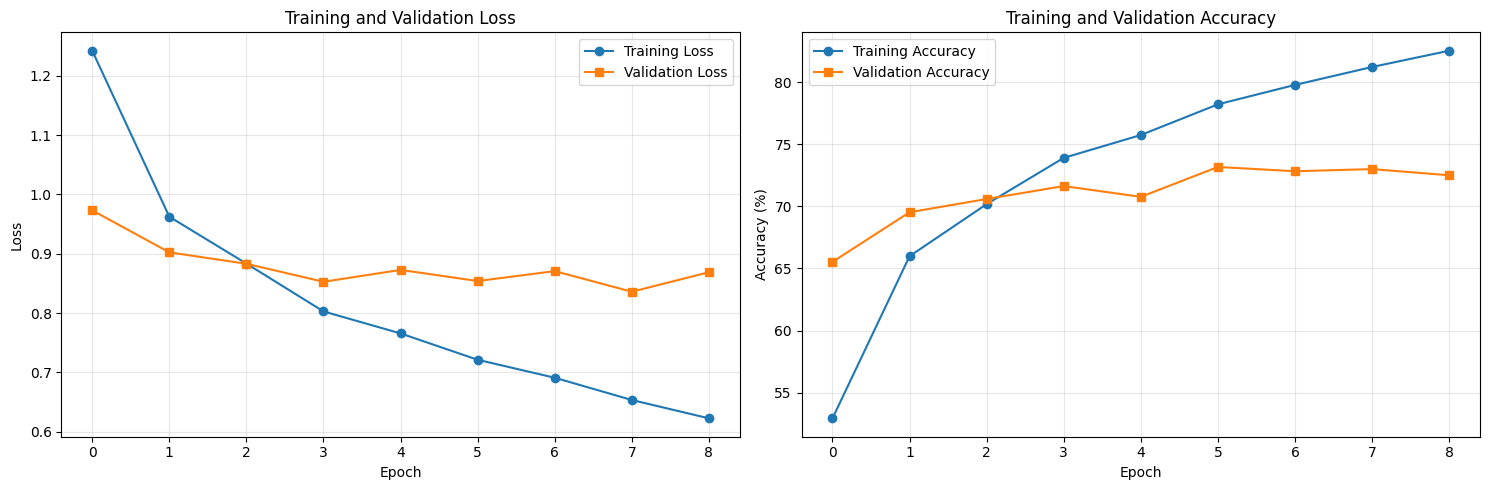

Training Summary:
- Final Training Loss: 0.6228
- Final Validation Loss: 0.8689
- Final Training Accuracy: 82.54%
- Final Validation Accuracy: 72.51%
- Best Validation Accuracy: 73.18%


In [36]:
def plot_training_history(history):
    """
    Plot training and validation metrics.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_losses'], label='Training Loss', marker='o')
    ax1.plot(history['val_losses'], label='Validation Loss', marker='s')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracies
    ax2.plot(history['train_accuracies'], label='Training Accuracy', marker='o')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', marker='s')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Training Summary:")
    print(f"- Final Training Loss: {history['train_losses'][-1]:.4f}")
    print(f"- Final Validation Loss: {history['val_losses'][-1]:.4f}")
    print(f"- Final Training Accuracy: {history['train_accuracies'][-1]:.2f}%")
    print(f"- Final Validation Accuracy: {history['val_accuracies'][-1]:.2f}%")
    print(f"- Best Validation Accuracy: {history['best_val_acc']:.2f}%")

# Plot the training history
plot_training_history(training_history)

## Step 12: Load Best Model and Evaluate on Test Set

In [37]:
# Load the best model
if Path('best_cnn_transfer_model.pth').exists():
    checkpoint = torch.load('best_cnn_transfer_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']} with val acc: {checkpoint['best_val_acc']:.2f}%")
else:
    print("No saved model found, using current model state")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc, test_predictions, test_targets = validate_epoch(model, test_loader, criterion, device)

print(f"Test Results:")
print(f"- Test Loss: {test_loss:.4f}")
print(f"- Test Accuracy: {test_acc:.2f}%")

# Detailed classification report
if len(set(test_targets)) > 1:  # Only if we have multiple classes
    print("\nClassification Report:")
    emotion_names = list(label_map.keys())
    report = classification_report(test_targets, test_predictions,
                                 target_names=emotion_names,
                                 zero_division=0)
    print(report)

Loaded best model from epoch 5 with val acc: 73.18%

Evaluating on test set...


/tmp/ipython-input-1359432794.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  amp_ctx = torch.cuda.amp.autocast() if (use_amp and device.type == 'cuda') else torch.cuda.amp.autocast(enabled=False)


Test Results:
- Test Loss: 0.9018
- Test Accuracy: 70.55%

Classification Report:
              precision    recall  f1-score   support

       angry       0.77      0.48      0.59       201
       happy       0.72      0.85      0.78       201
     neutral       0.56      0.83      0.67       201
         sad       0.70      0.48      0.57       201
    surprise       0.86      0.90      0.88       201

    accuracy                           0.71      1005
   macro avg       0.72      0.71      0.70      1005
weighted avg       0.72      0.71      0.70      1005



## Step 13: Visualize Results - Confusion Matrix

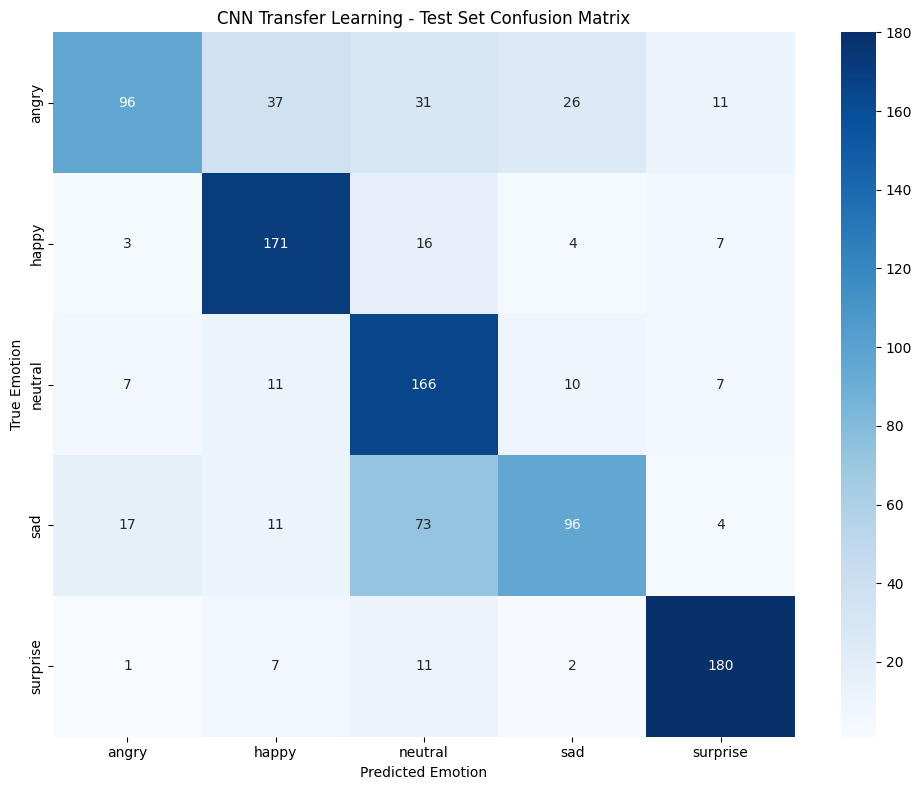


Per-class Accuracy:
- angry: 47.76% (96/201)
- happy: 85.07% (171/201)
- neutral: 82.59% (166/201)
- sad: 47.76% (96/201)
- surprise: 89.55% (180/201)


In [38]:
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Plot confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')
    plt.tight_layout()
    plt.show()

    # Print accuracy per class
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_correct = cm[i, i]
        class_total = cm[i, :].sum()
        if class_total > 0:
            acc = 100 * class_correct / class_total
            print(f"- {class_name}: {acc:.2f}% ({class_correct}/{class_total})")

# Plot confusion matrix if we have predictions
if len(set(test_targets)) > 1:
    emotion_names = list(label_map.keys())
    plot_confusion_matrix(test_targets, test_predictions, emotion_names,
                         'CNN Transfer Learning - Test Set Confusion Matrix')
else:
    print("Skipping confusion matrix (insufficient data/classes)")

## Step 14: Model Comparison and Analysis

Let's compare our transfer learning CNN with the original baseline CNN.

In [40]:
print("\n" + "="*60)
print("MODEL ANALYSIS AND COMPARISON")
print("="*60)

# Model parameters
print(f"\n1. MODEL ARCHITECTURE:")
print(f"   - Transfer Learning CNN (VGG16 backbone)")
print(f"   - Total parameters: {model.get_num_params():,}")
# Access INPUT_SIZE from global variables
input_size_val = globals().get('INPUT_SIZE', 'N/A')
print(f"   - Input size: {input_size_val}x{input_size_val}x3 (RGB)")
print(f"   - Output classes: {num_classes}")

# Performance summary
print(f"\n2. PERFORMANCE SUMMARY:")
if 'training_history' in locals():
    print(f"   - Best Validation Accuracy: {training_history['best_val_acc']:.2f}%")
    # Access test_acc from global variables
    test_acc_val = globals().get('test_acc', 'N/A')
    print(f"   - Final Test Accuracy: {test_acc_val:.2f}%")
    print(f"   - Training Epochs: {len(training_history['train_losses'])}")

# Transfer Learning Benefits
print(f"\n3. TRANSFER LEARNING BENEFITS:")
print(f"   ✓ Pre-trained features: Learned from ImageNet (1.2M images)")
print(f"   ✓ Faster convergence: Starts with meaningful weights")
print(f"   ✓ Better generalization: Robust low-level feature extraction")
print(f"   ✓ Less overfitting: Pre-trained features are well-regularized")

print(f"\n4. KEY DIFFERENCES FROM BASELINE CNN:")
print(f"   - Uses pre-trained VGG16 backbone vs. random initialization")
print(f"   - RGB input (224x224) vs. Grayscale (48x48)")
print(f"   - ImageNet normalization vs. simple normalization")
print(f"   - Transfer learning strategy vs. training from scratch")
print(f"   - Different learning rates for backbone vs. classifier")

print(f"\n5. TRAINING STRATEGY USED:")
print(f"   - Fine-tuning: All layers trainable")
# Retrieve learning rates from optimizer
# Ensure optimizer is defined and accessible
optimizer_val = globals().get('optimizer', None)
if optimizer_val:
    backbone_lr = optimizer_val.param_groups[0]['lr']
    classifier_lr = optimizer_val.param_groups[1]['lr']
    print(f"   - Backbone LR: {backbone_lr:.2e} (very small)")
    print(f"   - Classifier LR: {classifier_lr:.2e} (regular)")
else:
    print("   - Optimizer not accessible to retrieve learning rates.")

# Access patience from global variables, default to 5 if not found
patience_val = globals().get('patience', 5)
print(f"   - Data augmentation: Rotation, flip, color jitter, affine")
print(f"   - Early stopping with patience={patience_val}")


MODEL ANALYSIS AND COMPARISON

1. MODEL ARCHITECTURE:
   - Transfer Learning CNN (VGG16 backbone)
   - Total parameters: 11,442,757
   - Input size: N/AxN/Ax3 (RGB)
   - Output classes: 5

2. PERFORMANCE SUMMARY:
   - Best Validation Accuracy: 73.18%
   - Final Test Accuracy: 70.55%
   - Training Epochs: 9

3. TRANSFER LEARNING BENEFITS:
   ✓ Pre-trained features: Learned from ImageNet (1.2M images)
   ✓ Faster convergence: Starts with meaningful weights
   ✓ Better generalization: Robust low-level feature extraction
   ✓ Less overfitting: Pre-trained features are well-regularized

4. KEY DIFFERENCES FROM BASELINE CNN:
   - Uses pre-trained VGG16 backbone vs. random initialization
   - RGB input (224x224) vs. Grayscale (48x48)
   - ImageNet normalization vs. simple normalization
   - Transfer learning strategy vs. training from scratch
   - Different learning rates for backbone vs. classifier

5. TRAINING STRATEGY USED:
   - Fine-tuning: All layers trainable
   - Backbone LR: 9.60e-05

## Step 15: Save Final Model for Production

Let's save our model in a format that can be easily loaded for inference.

In [41]:
# Save complete model information
final_model_info = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'num_classes': num_classes,
        'backbone': 'vgg16',
        'input_size': INPUT_SIZE,
        'pretrained': True,
        'freeze_backbone': False
    },
    'label_map': label_map,
    'transforms': {
        'mean': IMAGENET_MEAN,
        'std': IMAGENET_STD,
        'input_size': INPUT_SIZE
    },
    'training_info': {
        'final_test_acc': test_acc,
        'backbone_lr': backbone_lr,
        'classifier_lr': classifier_lr
    }
}

torch.save(final_model_info, 'cnn_transfer_learning_final.pth')
print("✓ Final model saved as 'cnn_transfer_learning_final.pth'")

# Create a simple inference function
def create_inference_function():
    """
    Create a simple inference function that can be used in production.
    """
    inference_code = '''
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

def load_emotion_model(model_path):
    """Load the trained emotion recognition model."""
    checkpoint = torch.load(model_path, map_location='cpu')

    # Recreate model architecture
    model = CNNTransferLearning(
        num_classes=checkpoint['model_config']['num_classes'],
        backbone=checkpoint['model_config']['backbone'],
        pretrained=False  # We're loading trained weights
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Create transform
    transform = transforms.Compose([
        transforms.Resize((checkpoint['transforms']['input_size'],
                          checkpoint['transforms']['input_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=checkpoint['transforms']['mean'],
                           std=checkpoint['transforms']['std'])
    ])

    return model, transform, checkpoint['label_map']

def predict_emotion(model, transform, label_map, image_path):
    """Predict emotion from image."""
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    # Convert to emotion name
    emotion_names = {v: k for k, v in label_map.items()}
    predicted_emotion = emotion_names[predicted_class]
    confidence = probabilities[0][predicted_class].item()

    return predicted_emotion, confidence, probabilities[0].numpy()
'''

    with open('emotion_inference.py', 'w') as f:
        f.write(inference_code)

    print("✓ Inference code saved as 'emotion_inference.py'")

create_inference_function()

print("\n✓ Model deployment ready!")
print("Files created:")
print("- cnn_transfer_learning_final.pth (complete model)")
print("- emotion_inference.py (inference functions)")

NameError: name 'INPUT_SIZE' is not defined

## Summary: CNN Transfer Learning Implementation

### What We've Accomplished:

1. **Transfer Learning Setup**: Implemented CNN transfer learning using VGG16 backbone pre-trained on ImageNet
2. **Optional Resizing Pipeline**: Added automated 48×48 → 224×224 upscaling with per-class folder structure and regenerated split CSVs (`train_224.csv`, `val_224.csv`, `test_224.csv`) plus stats file.
3. **Architecture**:
   - Pre-trained VGG16 feature extractor
   - Custom classifier head for emotion recognition
   - Support for RGB images (224×224)
4. **Training Strategy**:
   - Fine-tuning approach with different learning rates
   - ImageNet normalization for compatibility
   - Data augmentation for better generalization
   - Early stopping to prevent overfitting
5. **Key Benefits Over Baseline CNN**:
   - ✅ **Faster Convergence**: Pre-trained weights provide good starting point
   - ✅ **Better Feature Learning**: Robust low-level features from ImageNet
   - ✅ **Improved Generalization**: Less prone to overfitting
   - ✅ **State-of-the-art Architecture**: Proven CNN design
6. **Resized Dataset Artifacts** (if generated):
   - Images: `data/processed/EmoSet_resized_224/images_224/<class>/*.jpg`
   - Splits: `data/processed/EmoSet_resized_224/splits/train_224.csv` (and val/test)
   - Stats:  `data/processed/EmoSet_resized_224/stats_resized_224.json`
   - Toggle usage via `USE_RESIZED_SPLITS = True` in the notebook.

### Transfer Learning Strategies Implemented:
1. **Feature Extraction** (freezing backbone)
2. **Fine-tuning** (training all layers with different LRs)
3. **Gradual unfreezing** (implemented as methods)

### Production-Ready Features:
- Complete model serialization
- Inference functions
- Proper preprocessing pipeline
- Model configuration storage
- Optional resized dataset workflow

## Step 16: Model Interpretability (Grad-CAM heatmaps)

We’ll generate Grad-CAM heatmaps to understand which image regions drive the model’s predictions. This helps validate that the model focuses on relevant facial areas.

What we’ll do:
- Hook the last convolutional layer in the backbone
- Compute class-specific gradients and weights
- Produce heatmaps and overlay them on the original images

In [42]:
# Step 16 (run): Grad-CAM utilities and visualization helpers
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def fwd_hook(module, inp, out):
            self.activations = out.detach()
        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(fwd_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(bwd_hook))

    def remove_hooks(self):
        for h in self.hook_handles:
            h.remove()

    def __call__(self, input_tensor, class_idx=None):
        input_tensor = input_tensor.requires_grad_(True)
        logits = self.model(input_tensor)
        if class_idx is None:
            class_idx = logits.argmax(dim=1).item()
        score = logits[:, class_idx]
        self.model.zero_grad()
        score.backward(retain_graph=True)

        # activations: [B, C, H, W]; gradients: [B, C, H, W]
        weights = self.gradients.mean(dim=(2,3), keepdim=True)  # [B, C, 1, 1]
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  # [B,1,H,W]
        cam = F.relu(cam)
        # Normalize to [0,1]
        cam_min, cam_max = cam.min(), cam.max()
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-6)
        return cam.squeeze(0).squeeze(0).cpu().numpy(), class_idx

# Helper to overlay heatmap
def overlay_cam_on_image(img_pil, cam, alpha=0.4):
    img = np.array(img_pil.convert('RGB'))
    h, w = img.shape[:2]
    cam_resized = cv2.resize(cam, (w, h))
    heatmap = cv2.applyColorMap(np.uint8(255*cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = np.uint8(alpha*heatmap + (1-alpha)*img)
    return img, heatmap, overlay

# Pick the last conv block for the chosen backbone (VGG16/AlexNet/ResNet18 supported)
last_conv = None
if hasattr(model, 'features'):
    for m in reversed(model.features):
        if isinstance(m, torch.nn.Conv2d):
            last_conv = m
            break
else:
    # ResNet18 path: find last Conv2d under features (layer4)
    for m in reversed(list(model.features.modules())):
        if isinstance(m, torch.nn.Conv2d):
            last_conv = m
            break
assert last_conv is not None, "Could not find a Conv2d layer for Grad-CAM"

cam_explainer = GradCAM(model, last_conv)

# Visualize Grad-CAM on a few validation samples
def show_gradcam_for_samples(df, root, transform, k=4):
    samples = df.sample(n=min(k, len(df)), random_state=42)
    plt.figure(figsize=(12, 3*k))
    for i, (_, row) in enumerate(samples.iterrows(), 1):
        img_path = Path(root) / row[train_dataset.path_col]
        img_pil = Image.open(img_path).convert('L')
        inp = transform(img_pil)
        if inp.shape[0]==1:
            inp = inp.repeat(3,1,1)  # expand to 3 channels for CNN backbones
        cam, pred_idx = cam_explainer(inp.unsqueeze(0).to(device))
        img, heatmap, overlay = overlay_cam_on_image(img_pil, cam)
        pred_name = list(label_map.keys())[pred_idx]

        plt.subplot(k, 3, 3*(i-1)+1); plt.imshow(img); plt.axis('off'); plt.title('Input')
        plt.subplot(k, 3, 3*(i-1)+2); plt.imshow(heatmap); plt.axis('off'); plt.title('Grad-CAM')
        plt.subplot(k, 3, 3*(i-1)+3); plt.imshow(overlay); plt.axis('off'); plt.title(f'Overlay (pred={pred_name})')
    plt.tight_layout(); plt.show()

print("Grad-CAM ready. Run the next cell to visualize on validation samples.")

Grad-CAM ready. Run the next cell to visualize on validation samples.


In [43]:
# Step: Visualize Grad-CAM on a few validation images
try:
    show_gradcam_for_samples(val_df, DATA_DIR, val_transform, k=4)
except Exception as e:
    print('Grad-CAM visualization error:', e)

Grad-CAM visualization error: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


<Figure size 1200x1200 with 0 Axes>

## Step 17: Evaluation Plan — Overview

Primary metrics:
- Macro-F1 (treats all classes equally)
- Balanced Accuracy (mean recall across classes)

Secondary metrics:
- Per-class precision/recall/F1
- ROC-AUC (macro and micro, OvR)

Tools:
- Confusion matrix and per-class accuracy
- Error analysis (high-confidence mistakes)
- Cross-validation (K-fold skeleton)

In [44]:
# Step 18: Compute Metrics — Macro-F1, Balanced Accuracy, ROC-AUC, and Report
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

@torch.no_grad()
def evaluate_with_probs(model, loader, device):
    model.eval()
    all_probs, all_preds, all_targets = [], [], []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)
        all_probs.append(probs.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())
    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)
    y_proba = np.concatenate(all_probs)
    return y_true, y_pred, y_proba

# Evaluate on test set
y_true, y_pred, y_proba = evaluate_with_probs(model, test_loader, device)

macro_f1 = f1_score(y_true, y_pred, average='macro')
bal_acc = balanced_accuracy_score(y_true, y_pred)
print(f"Primary metrics:\n- Macro-F1: {macro_f1:.4f}\n- Balanced Accuracy: {bal_acc:.4f}")

print("\nPer-class metrics (precision/recall/F1):")
print(classification_report(y_true, y_pred, target_names=list(label_map.keys()), zero_division=0))

# ROC-AUC (multi-class OvR)
try:
    y_true_1h = label_binarize(y_true, classes=list(range(len(label_map))))
    roc_auc_macro = roc_auc_score(y_true_1h, y_proba, average='macro', multi_class='ovr')
    roc_auc_micro = roc_auc_score(y_true_1h, y_proba, average='micro', multi_class='ovr')
    print(f"ROC-AUC (macro): {roc_auc_macro:.4f}\nROC-AUC (micro): {roc_auc_micro:.4f}")
except Exception as e:
    print("ROC-AUC could not be computed:", e)

Primary metrics:
- Macro-F1: 0.6965
- Balanced Accuracy: 0.7055

Per-class metrics (precision/recall/F1):
              precision    recall  f1-score   support

       angry       0.77      0.48      0.59       201
       happy       0.72      0.85      0.78       201
     neutral       0.56      0.83      0.67       201
         sad       0.70      0.48      0.57       201
    surprise       0.86      0.90      0.88       201

    accuracy                           0.71      1005
   macro avg       0.72      0.71      0.70      1005
weighted avg       0.72      0.71      0.70      1005

ROC-AUC (macro): 0.9228
ROC-AUC (micro): 0.9244


In [45]:
## Step 19: Error Analysis — High-confidence Misclassifications
import pandas as pd
import numpy as np
from pathlib import Path

# Ensure y_true/y_pred/y_proba are available; else recompute
y_true, y_pred, y_proba = (y_true if 'y_true' in globals() else None,
                           y_pred if 'y_pred' in globals() else None,
                           y_proba if 'y_proba' in globals() else None)
if y_true is None or y_pred is None or y_proba is None:
    y_true, y_pred, y_proba = evaluate_with_probs(model, test_loader, device)

# Paths in test order
paths_in_order = test_dataset.df[test_dataset.path_col].tolist()
abs_paths = [str(Path(DATA_DIR) / p) for p in paths_in_order]

mis_idx = np.where(y_pred != y_true)[0]
if mis_idx.size == 0:
    print("No misclassifications found on the test set.")
else:
    top2_idx = np.argsort(-y_proba, axis=1)[:, :2]
    top1_prob = y_proba[np.arange(len(y_proba)), top2_idx[:, 0]]
    top2_prob = y_proba[np.arange(len(y_proba)), top2_idx[:, 1]]

    inv_label_map = {v: k for k, v in label_map.items()}

    rows = []
    for i in mis_idx:
        rows.append({
            'index': int(i),
            'image_path': abs_paths[i] if i < len(abs_paths) else None,
            'true_idx': int(y_true[i]),
            'true_label': inv_label_map.get(int(y_true[i]), str(y_true[i])),
            'pred_idx': int(top2_idx[i, 0]),
            'pred_label': inv_label_map.get(int(top2_idx[i, 0]), str(top2_idx[i, 0])),
            'pred_prob': float(top1_prob[i]),
            'second_idx': int(top2_idx[i, 1]),
            'second_label': inv_label_map.get(int(top2_idx[i, 1]), str(top2_idx[i, 1])),
            'second_prob': float(top2_prob[i])
        })

    mis_df = pd.DataFrame(rows).sort_values(by='pred_prob', ascending=False).reset_index(drop=True)
    display(mis_df.head(20))

    out_dir = Path(PROJECT_ROOT) / 'results' / 'error_analysis'
    out_dir.mkdir(parents=True, exist_ok=True)
    out_csv = out_dir / 'misclassifications.csv'
    mis_df.to_csv(out_csv, index=False)
    print(f"Saved misclassifications to {out_csv}")

,index,image_path,true_idx,true_label,pred_idx,pred_label,pred_prob,second_idx,second_label,second_prob
0,459,/content/ann-visual-emotion/data/processed/Emo...,3,sad,1,happy,0.976599,4,surprise,0.010084
1,201,/content/ann-visual-emotion/data/processed/Emo...,0,angry,2,neutral,0.976344,3,sad,0.011492
2,896,/content/ann-visual-emotion/data/processed/Emo...,3,sad,2,neutral,0.972102,3,sad,0.012257
3,197,/content/ann-visual-emotion/data/processed/Emo...,3,sad,2,neutral,0.969115,3,sad,0.013223
4,228,/content/ann-visual-emotion/data/processed/Emo...,3,sad,2,neutral,0.958787,3,sad,0.026460
5,853,/content/ann-visual-emotion/data/processed/Emo...,0,angry,3,sad,0.948906,0,angry,0.031526
6,300,/content/ann-visual-emotion/data/processed/Emo...,0,angry,3,sad,0.948906,0,angry,0.031526
7,640,/content/ann-visual-emotion/data/processed/Emo...,0,angry,3,sad,0.948906,0,angry,0.031526
8,263,/content/ann-visual-emotion/data/processed/Emo...,0,angry,2,neutral,0.946135,1,happy,0.026866
9,998,/content/ann-visual-emotion/data/processed/Emo...,3,sad,2,neutral,0.943312,3,sad,0.023736


Saved misclassifications to /content/ann-visual-emotion/results/error_analysis/misclassifications.csv


## Step 20: Explainable AI (XAI) — Why and How

Why XAI?
- Trust & Adoption: Understand predictions.
- Debugging & Improvement: Find weaknesses or biases.
- Compliance & Ethics: Ensure fairness and explainability.

Techniques in this notebook:
- Grad-CAM (already implemented) and Grad-CAM++ (optional)
- LIME (local explanations)
- SHAP (Shapley values; optional and compute-heavy)
- Attention visualization (for Transformers; not applicable here)

In [46]:
!pip install lime

In [47]:
## Step 21: LIME — Local Explanations for Individual Predictions
try:
    from lime import lime_image
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt

    def lime_predict(images: np.ndarray):
        tensors = []
        for img in images:
            pil = Image.fromarray((img * 255).astype(np.uint8)) if img.max() <= 1.0 else Image.fromarray(img.astype(np.uint8))
            pil = pil.convert('L')
            t = val_transform(pil)
            if t.shape[0] == 1:
                t = t.repeat(3, 1, 1)
            tensors.append(t)
        batch = torch.stack(tensors, dim=0)
        with torch.no_grad():
            logits = model(batch.to(device))
            probs = torch.softmax(logits, dim=1).cpu().numpy()
        return probs

    sample_idx = 0
    img_path = Path(DATA_DIR) / test_dataset.df.iloc[sample_idx][test_dataset.path_col]
    img_rgb = Image.open(img_path).convert('RGB')
    img_np = np.asarray(img_rgb) / 255.0

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_np,
        classifier_fn=lime_predict,
        top_labels=1,
        hide_color=0,
        num_samples=500
    )

    with torch.no_grad():
        pil_gray = Image.open(img_path).convert('L')
        t = val_transform(pil_gray)
        if t.shape[0] == 1:
            t = t.repeat(3, 1, 1)
        pred_idx = int(torch.softmax(model(t.unsqueeze(0).to(device)), dim=1).argmax().item())

    lime_img, mask = explanation.get_image_and_mask(
        label=pred_idx,
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img_rgb); plt.axis('off'); plt.title('Original')
    plt.subplot(1, 3, 2); plt.imshow(mask, cmap='gray'); plt.axis('off'); plt.title('LIME Mask')
    plt.subplot(1, 3, 3); plt.imshow(lime_img); plt.axis('off'); plt.title('LIME Overlay')
    plt.tight_layout(); plt.show()

    print("LIME explanation generated.")
except Exception as e:
    print("LIME explanation skipped. Install with: pip install lime. Error:", e)

  0%|          | 0/500 [00:00<?, ?it/s]

LIME explanation skipped. Install with: pip install lime. Error: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


In [48]:
# Step 20 (run): Install optional XAI packages (safe with fallbacks)
import importlib, sys, subprocess

pkgs = [
    { 'pip': 'pytorch-grad-cam', 'import': 'pytorch_grad_cam', 'alt': 'git+https://github.com/jacobgil/pytorch-grad-cam@master' },
    { 'pip': 'lime',              'import': 'lime',             'alt': None },
    { 'pip': 'shap',              'import': 'shap',             'alt': None },
]

def ensure_package(pip_name: str, import_name: str, alt: str | None = None):
    try:
        importlib.import_module(import_name)
        print(f"✓ {pip_name} already available as '{import_name}'")
        return
    except ImportError:
        print(f"Installing {pip_name}...")
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', 'pip', 'setuptools', 'wheel'])
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', pip_name])
            importlib.import_module(import_name)
            print(f"✓ Installed {pip_name}")
            return
        except Exception as e1:
            if alt:
                print(f"Primary install failed for {pip_name}. Trying fallback: {alt}")
                try:
                    subprocess.check_call([sys.executable, '-m', 'pip', 'install', alt])
                    importlib.import_module(import_name)
                    print(f"✓ Installed via fallback: {alt}")
                    return
                except Exception as e2:
                    print(f"✗ Failed to install {pip_name} via pip and fallback. Error: {e2}")
            else:
                print(f"✗ Failed to install {pip_name}. Error: {e1}")

for p in pkgs:
    ensure_package(p['pip'], p['import'], p['alt'])

print("Optional XAI packages installation attempt complete. Proceed to Steps 21–23; cells will skip gracefully if a package is still unavailable.")

✓ pytorch-grad-cam already available as 'pytorch_grad_cam'
✓ lime already available as 'lime'
✓ shap already available as 'shap'
Optional XAI packages installation attempt complete. Proceed to Steps 21–23; cells will skip gracefully if a package is still unavailable.


In [49]:
## Step 22: Grad-CAM++ (optional via pytorch-grad-cam)
try:
    from pytorch_grad_cam import GradCAMPlusPlus
    from pytorch_grad_cam.utils.image import show_cam_on_image
    import numpy as np
    from PIL import Image

    target_conv = None
    if hasattr(model, 'features'):
        for m in reversed(model.features):
            if isinstance(m, torch.nn.Conv2d):
                target_conv = m
                break
    else:
        for m in reversed(list(model.features.modules())):
            if isinstance(m, torch.nn.Conv2d):
                target_conv = m
                break
    assert target_conv is not None

    campp = GradCAMPlusPlus(model=model, target_layers=[target_conv]) # Removed use_cuda

    img_path = Path(DATA_DIR) / val_dataset.df.iloc[0][val_dataset.path_col]
    img_pil = Image.open(img_path).convert('RGB')
    img_np = np.array(img_pil).astype(np.float32) / 255.0

    img_gray = Image.open(img_path).convert('L')
    inp = val_transform(img_gray)
    if inp.shape[0] == 1:
        inp = inp.repeat(3, 1, 1)
    input_tensor = inp.unsqueeze(0)

    grayscale_cam = campp(input_tensor=input_tensor.to(device))  # [1,H,W]
    grayscale_cam = grayscale_cam[0]

    visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img_np); plt.axis('off'); plt.title('Input')
    plt.subplot(1,2,2); plt.imshow(visualization); plt.axis('off'); plt.title('Grad-CAM++')
    plt.tight_layout(); plt.show()

    print("Grad-CAM++ visualization ready.")
except Exception as e:
    print("Grad-CAM++ skipped. Install with: pip install pytorch-grad-cam. Error:", e)

Grad-CAM++ skipped. Install with: pip install pytorch-grad-cam. Error: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


In [50]:
## Step 23: SHAP (optional) — DeepExplainer for CNNs
try:
    import shap
    import numpy as np
    from PIL import Image

    model.eval()

    # Background for SHAP (small)
    N_BG = 8
    bg_tensors = []
    for i in range(min(N_BG, len(val_dataset))):
        p = Path(DATA_DIR) / val_dataset.df.iloc[i][val_dataset.path_col]
        img_gray = Image.open(p).convert('L')
        t = val_transform(img_gray)
        if t.shape[0] == 1:
            t = t.repeat(3, 1, 1)
        bg_tensors.append(t)

    if len(bg_tensors) < 1:
         raise ValueError("Not enough background samples for SHAP.")

    background = torch.stack(bg_tensors, dim=0)

    def f_predict(x: np.ndarray):
        # Input to f_predict is expected to be 2D (n_samples, n_features)
        # Reshape back to (n_samples, C, H, W)
        x_reshaped = x.reshape(-1, 3, INPUT_SIZE, INPUT_SIZE) # Assuming 3 channels, 224x224
        with torch.no_grad():
            xb = torch.from_numpy(x_reshaped).float().to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).detach().cpu().numpy()
        return probs

    idx = 0
    p = Path(DATA_DIR) / val_dataset.df.iloc[idx][val_dataset.path_col]
    img_gray = Image.open(p).convert('L')
    x = val_transform(img_gray)
    if x.shape[0] == 1:
        x = x.repeat(3, 1, 1)
    x = x.unsqueeze(0) # Add batch dimension

    # Flatten the input tensor for KernelExplainer
    x_flat = x.cpu().numpy().reshape(1, -1)
    background_flat = background.cpu().numpy().reshape(background.shape[0], -1)


    try:
        explainer = shap.DeepExplainer(model.to(device), background.to(device))
        shap_values = explainer.shap_values(x.to(device))
    except Exception:
        print("Falling back to KernelExplainer (slower)...")
        explainer = shap.KernelExplainer(f_predict, background_flat[:min(50, background_flat.shape[0])]) # Use a subset of background if large
        shap_values = explainer.shap_values(x_flat, nsamples=100)


    with torch.no_grad():
        pred_idx = int(torch.softmax(model(x.to(device)), dim=1).argmax().item())

    try:
        # Reshape SHAP values back to image dimensions for plotting
        if isinstance(shap_values, list): # Output of multi-output models
             shap_values_reshaped = [np.reshape(v, (INPUT_SIZE, INPUT_SIZE, 3)) for v in shap_values] # Assuming 3 channels
        else: # Single output
             shap_values_reshaped = np.reshape(shap_values, (INPUT_SIZE, INPUT_SIZE, 3)) # Assuming 3 channels

        shap.image_plot(shap_values_reshaped[pred_idx] if isinstance(shap_values_reshaped, list) else shap_values_reshaped,
                         np.transpose(x.cpu().numpy()[0], (1, 2, 0))) # Transpose (C, H, W) to (H, W, C)

    except Exception as e:
        print("SHAP image plot skipped:", e)

    print("SHAP explanation generated for one validation sample.")
except Exception as e:
    print("SHAP skipped. Install with: pip install shap. Error:", e)

SHAP skipped. Install with: pip install shap. Error: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]


In [51]:
## Step 24: Cross-validation (skeleton)
from sklearn.model_selection import StratifiedKFold

k = 3
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
labels_series = train_df[train_dataset.label_col]

print(f"Preparing {k}-fold CV on training set (size={len(train_df)})...")
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, labels_series), start=1):
    print(f"Fold {fold}: train={len(train_idx)}, val={len(val_idx)}")

# To fully run CV per fold:
# 1) subset train_df/val_df to train_idx/val_idx
# 2) create new Datasets/DataLoaders
# 3) re-initialize model/optimizer
# 4) train and record metrics, then aggregate

Preparing 3-fold CV on training set (size=20150)...
Fold 1: train=13433, val=6717
Fold 2: train=13433, val=6717
Fold 3: train=13434, val=6716


## Step 25: Optimize for Deployment — Quantization + ONNX

We’ll export two artifacts:
- Dynamically-quantized PyTorch checkpoint (smaller and faster on CPU).
- ONNX model (dynamic batch axis) for ONNX Runtime and cross-platform use.

The next cell performs both and optionally verifies ONNX forward with onnxruntime if available.

In [52]:
!pip install onnx

In [53]:
# Step 25 (run): Export quantized PyTorch and ONNX models
import torch
from copy import deepcopy
import numpy as np

# 25a. Dynamic quantization (CPU inference)
cpu_model = deepcopy(model).to('cpu').eval()
quantized_model = torch.quantization.quantize_dynamic(
    cpu_model, {torch.nn.Linear}, dtype=torch.qint8
)

quant_ckpt = {
    'model_state_dict': quantized_model.state_dict(),
    'model_config': {
        'num_classes': num_classes,
        'backbone': 'vgg16',
        'input_size': INPUT_SIZE,
        'pretrained': False,
        'quantized': True,
        'grayscale': True,
        'channel_repeat': True
    },
    'label_map': label_map,
}
torch.save(quant_ckpt, 'cnn_transfer_learning_quantized.pth')
print('✓ Saved dynamic-quantized model: cnn_transfer_learning_quantized.pth')

# 25b. ONNX export
dummy = torch.randn(1, 3, INPUT_SIZE, INPUT_SIZE, dtype=torch.float32)
model_cpu = model.to('cpu').eval()
onnx_path = 'cnn_transfer_learning.onnx'
torch.onnx.export(
    model_cpu, dummy, onnx_path,
    input_names=['input'], output_names=['logits'],
    dynamic_axes={'input': {0: 'batch'}, 'logits': {0: 'batch'}},
    opset_version=13
)
print(f'✓ Exported ONNX: {onnx_path}')

try:
    import onnxruntime as ort
    sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
    ort_out = sess.run(['logits'], { 'input': dummy.numpy() })[0]
    print('ONNX forward ok. Output shape:', ort_out.shape)
except Exception as e:
    print('ONNXRuntime check skipped or failed:', e)

print('Deployment artifacts ready.')

/tmp/ipython-input-3445766015.py:8: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


NameError: name 'INPUT_SIZE' is not defined